In [1]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift

In [2]:
def rotate(axis, theta, points):
    """
    Rotate points by theta degrees around the given axis
    """
    theta = np.radians(theta)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    if axis == 'xy':
        rotation_matrix = np.array([[cos_theta, -sin_theta, 0],
                                    [sin_theta, cos_theta, 0],
                                    [0, 0, 1]])
    elif axis == 'yz':
        rotation_matrix = np.array([[1, 0, 0],
                                    [0, cos_theta, -sin_theta],
                                    [0, sin_theta, cos_theta]])
        
    else:
        raise ValueError('Invalid axis. Must be either "xy" or "yz"')
    
    rotated_points = np.einsum('ij,jabc->iabc', rotation_matrix, points)
    return rotated_points

def simulate_diffusion(simsize, bmax, bigDelta, smallDelta, gmax, gamma, FA, Dxx_base, fiber_fractions, angle_xy, angle_yz):
    qmax = gamma / (2 * np.pi) * smallDelta * gmax
    qDelta = qmax * 2 / (simsize - 1)
    rFOV = 1 / qDelta
    rmax = rFOV / 2

    # Create grid for R-space
    grid = np.linspace(-rmax, rmax, simsize)
    X, Y, Z = np.meshgrid(grid, grid, grid, indexing='ij')

    # Coefficients for R-space normalization
    pi_coeff = (4 * np.pi * bigDelta) ** 3
    
    rspaces = []

    # Diffusion simulation
    rspace_total = np.zeros_like(X)
    
    for i in range(len(fiber_fractions)):
        # print(len(fiber_fractions))
        fr = fiber_fractions[i]
        a_xy = angle_xy[i]
        a_xz = angle_yz[i]
        Dxx = Dxx_base

        # print(f'Fraction: {fr}, Angle XY: {a_xy}, Angle YZ: {a_yz}, Dxx: {Dxx}')

        # Calculate fiber rotation around y-z plane:
        # angle = np.radians(a_yz)
        # cos_angle, sin_angle = np.cos(angle), np.sin(angle)
        # Yr = Y * cos_angle + Z * sin_angle
        # Zr = Z * cos_angle - Y * sin_angle

        # Calculate fiber rotation around x-y plane:
        angle = np.radians(a_xy)
        cos_angle, sin_angle = np.cos(angle), np.sin(angle)
        Xr = X * cos_angle + Y * sin_angle
        Yr = Y * cos_angle - X * sin_angle
        
        # Calculate fiber rotation around x-z plane:
        angle = np.radians(a_xz)
        cos_angle, sin_angle = np.cos(angle), np.sin(angle)
        Xr = Xr * cos_angle + Z * sin_angle
        Zr = Z * cos_angle - Xr * sin_angle
        
        print(f'Fraction: {fr}, Number: {i}, Angle XY: {a_xy}, Angle XZ: {a_xz}, Dxx: {Dxx}')
            
        # Diffusion coefficients, updated to vary per fiber
        Dyy = Dxx * (1 - FA) / np.sqrt(2)
        Dzz = Dxx * (1 - FA) / np.sqrt(2)
    
        # R-space distribution for the current fiber
        rspace = 1 / np.sqrt(pi_coeff * Dxx * Dyy * Dzz) * np.exp(
            -(Xr ** 2 / (4 * Dxx * bigDelta) + Yr ** 2 / (4 * Dyy * bigDelta) + Zr ** 2 / (4 * Dzz * bigDelta)))
    
        rspace_total += fr * rspace
        rspaces.append(fr * rspace)

    # Fourier transform to Q-space (Signal)
    qspace = fftshift(fftn(ifftshift(rspace_total)))

    # Work with the magnitude of the qspace, disregard the phase information
    qspace = np.abs(qspace)

    return rspace_total, qspace, rspaces

In [3]:
# Parameters
n_samples = 5  # Number of different samples to generate
simsize = 33
bmax = 10000  # s/mm^2
bigDelta = 66e-3  # sec
smallDelta = 60e-3  # sec
gmax = 40e-3  # T/m
gamma = 2 * np.pi * 42.57e6  # Hz/T for proton
Dxx_individual = np.array([3e-10])  # m^2/s
FA = 0.9  # Fractional anisotropy
fiber_fractions = np.array([.5, .5])
angle_xy = np.array([0., 45.])
angle_yz = np.array([0., 45.])

save_dir = 'data'

In [4]:
rspace, qspace, rspaces = simulate_diffusion(simsize, bmax, bigDelta, smallDelta, gmax, gamma, FA, Dxx_individual, fiber_fractions, angle_xy, angle_yz)

Fraction: 0.5, Number: 0, Angle XY: 0.0, Angle XZ: 0.0, Dxx: [3.e-10]
Fraction: 0.5, Number: 1, Angle XY: 45.0, Angle XZ: 45.0, Dxx: [3.e-10]


In [5]:
print(rspace.shape)
print(qspace.shape)
print(len(rspaces))

(33, 33, 33)
(33, 33, 33)
2


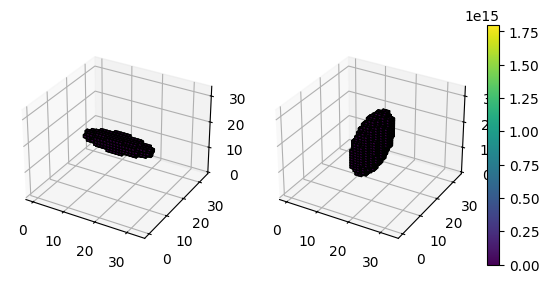

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

def plot_multiple_rspaces_side_by_side(rspaces, save_str):
    up_th = 26166721854964.797
    low_th = 3.5030014994588684-3

    # Determine layout of subplots
    num_rspaces = len(rspaces)
    cols = int(np.ceil(np.sqrt(num_rspaces)))
    rows = int(np.ceil(num_rspaces / cols))

    fig = plt.figure(figsize=(cols * 3, rows * 3))
    norm = Normalize(vmin=min(rs.min() for rs in rspaces), vmax=max(rs.max() for rs in rspaces))

    for i, rspace in enumerate(rspaces):
        ax = fig.add_subplot(rows, cols, i+1, projection='3d')
        fill = np.where((rspace > low_th) & (rspace < up_th), 1, 0)
        ax.voxels(fill, facecolors=plt.cm.viridis(norm(rspace)), edgecolors='k')

    # Add a colorbar and adjust its position
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
    mappable.set_array([])
    cb_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    plt.colorbar(mappable, cax=cb_ax)

    plt.show()

# Example usage with your list of rspaces
plot_multiple_rspaces_side_by_side(rspaces, 'test')


In [7]:
'' 

''

In [8]:
import matplotlib.pyplot as plt

for i in range(len(rspaces)):
    plot_rspace(rspaces[i], str(i))
    

NameError: name 'plot_rspace' is not defined

0.0
3603316550013168.0
Number of zeros in r-space data: 5962
Number of infinities in r-space data: 0
Number of NaNs in r-space data: 0
(33, 33, 33)


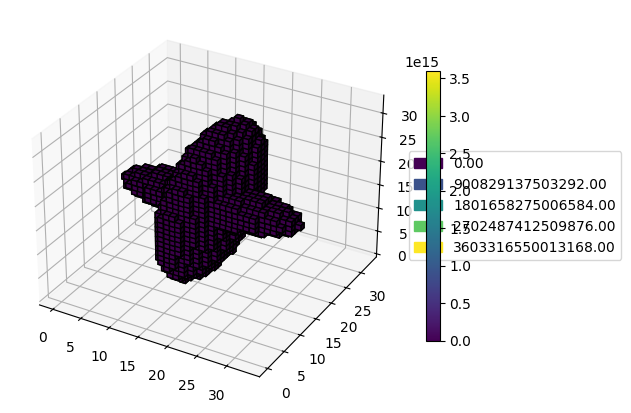

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

print(np.min(rspace))
print(np.max(rspace))
up_th = 261667218549640.797
low_th = 3.5030014994588684e-15

# Create np array where values between the thresholds are set to 1
fill = np.where((rspace > low_th) & (rspace < up_th), 1, 0)


# Count number of zeros in the r-space data
print(f'Number of zeros in r-space data: {np.sum(rspace == 0)}')
print(f'Number of infinities in r-space data: {np.sum(np.isinf(rspace))}')
print(f'Number of NaNs in r-space data: {np.sum(np.isnan(rspace))}')
print(rspace.shape)

# Plot the r-space data
norm = Normalize(vmin=rspace.min(), vmax=rspace.max())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(filled=fill, facecolors=plt.cm.viridis(rspace), edgecolors='k')

# Create a colorbar with the viridis colormap
mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
mappable.set_array([])
plt.colorbar(mappable, ax=ax, shrink=0.6)

# Create legend patches
legend_patches = [Patch(color=plt.cm.viridis(norm(value)), label=f'{value:.2f}') for value in np.linspace(rspace.min(), rspace.max(), num=5)]
# Add legend to plot
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
